In [1]:
!pip install kagglehub
from google.colab import files

import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [00:15<00:00, 191MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [2]:
import os

# Define the dataset path
root_folder = "/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"

data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

# Count the number of folders in a directory
def count_folders(path):
    if os.path.exists(path):
        return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Count the number of files in a directory
def count_files(path):
    if os.path.exists(path):
        return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Function to count files in each folder of a given directory
def count_files_in_folders(path):
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return {}

    folder_file_counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_file_counts[folder] = file_count

    return folder_file_counts

# Print counts
print(f"Number of folders in train_path: {count_folders(train_path)}")
print(f"Number of folders in valid_path: {count_folders(valid_path)}")
print(f"Number of files in test_path: {count_files(test_path)}")
print('-------------------------------------------------------------------')
# Count files in each folder
train_folder_counts = count_files_in_folders(train_path)
valid_folder_counts = count_files_in_folders(valid_path)
# Display results
print("Files in each folder (train_path):")
for folder, count in train_folder_counts.items():
    print(f"{folder}: {count} files")

print("\nFiles in each folder (valid_path):")
for folder, count in valid_folder_counts.items():
    print(f"{folder}: {count} files")

Number of folders in train_path: 38
Number of folders in valid_path: 38
Number of files in test_path: 33
-------------------------------------------------------------------
Files in each folder (train_path):
Tomato___Tomato_mosaic_virus: 1790 files
Tomato___Leaf_Mold: 1882 files
Tomato___healthy: 1926 files
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 files
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 files
Grape___healthy: 1692 files
Strawberry___healthy: 1824 files
Tomato___Late_blight: 1851 files
Tomato___Bacterial_spot: 1702 files
Corn_(maize)___Northern_Leaf_Blight: 1908 files
Grape___Esca_(Black_Measles): 1920 files
Tomato___Spider_mites Two-spotted_spider_mite: 1741 files
Peach___healthy: 1728 files
Raspberry___healthy: 1781 files
Blueberry___healthy: 1816 files
Potato___Early_blight: 1939 files
Soybean___healthy: 2022 files
Cherry_(including_sour)___Powdery_mildew: 1683 files
Strawberry___Leaf_scorch: 1774 files
Corn_(maize)___Common_rust_: 1907 files
Potato___Late_blight: 

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import glob
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Initialize lists
image_paths = []
species_labels = []
disease_labels = []
dataset_split = []

# Function to process a dataset directory
def process_directory(base_path, split_name):
    for class_folder in os.listdir(base_path):
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):
            species, disease = class_folder.split('___')
            for image_name in os.listdir(class_folder_path):
                image_paths.append(os.path.join(class_folder_path, image_name))
                species_labels.append(species)
                disease_labels.append(disease)
                dataset_split.append(split_name)

# Process train and valid
process_directory(train_path, 'train')
process_directory(base_path=valid_path, split_name='valid')

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'species': species_labels,
    'disease': disease_labels,
    'split': dataset_split
})

# Display first few rows
print(df.head())

                                          image_path species  \
0  /root/.cache/kagglehub/datasets/vipoooool/new-...  Tomato   
1  /root/.cache/kagglehub/datasets/vipoooool/new-...  Tomato   
2  /root/.cache/kagglehub/datasets/vipoooool/new-...  Tomato   
3  /root/.cache/kagglehub/datasets/vipoooool/new-...  Tomato   
4  /root/.cache/kagglehub/datasets/vipoooool/new-...  Tomato   

               disease  split  
0  Tomato_mosaic_virus  train  
1  Tomato_mosaic_virus  train  
2  Tomato_mosaic_virus  train  
3  Tomato_mosaic_virus  train  
4  Tomato_mosaic_virus  train  


Model path and augmentation incl. validation data set

In [8]:
# Define paths
train_dir = train_path
valid_dir = valid_path

# Get the number of classes in the training set
num_classes = 38

# Image data generators
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'categorical')

print(f"Classes in train generator: {train_generator.class_indices}")
print(f"Classes in valid generator: {valid_generator.class_indices}")

# Check data shape and batch sizes
batch_images, batch_labels = next(train_generator)
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Classes in train generator: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawb

Define and compile the model incl. EarlyStopping

In [12]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(num_classes, activation = 'softmax')])

# Compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Apply EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'accuracy',
    patience = 5,
    restore_best_weights = True)

#  steps_per_epoch & validation_steps are re-calculated
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size


Run the training on the defined model

In [13]:
# Train the model
model.fit(train_generator,
          steps_per_epoch = steps_per_epoch,
          epochs = 20,
          validation_data = valid_generator,
          validation_steps = validation_steps,
          )

Epoch 1/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 379s 171ms/step - accuracy: 0.4776 - loss: 1.8353 - val_accuracy: 0.8394 - val_loss: 0.5096
Epoch 2/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1s 284us/step - accuracy: 0.8750 - loss: 0.3210 - val_accuracy: 0.7500 - val_loss: 0.7903
Epoch 3/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 376s 171ms/step - accuracy: 0.8511 - loss: 0.4664 - val_accuracy: 0.8776 - val_loss: 0.3823
Epoch 4/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.9375 - loss: 0.1457 - val_accuracy: 0.7500 - val_loss: 0.4124
Epoch 5/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 373s 170ms/step - accuracy: 0.9057 - loss: 0.2910 - val_accuracy: 0.9082 - val_loss: 0.2749
Epoch 6/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.2594
Epoch 7/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 371s 169ms/step - accuracy: 0.9283 - loss: 0.2227 - val_accuracy: 0.9084 - val_loss: 0.2831
Epoch 8/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.8750

Plot the accuracy and loss results

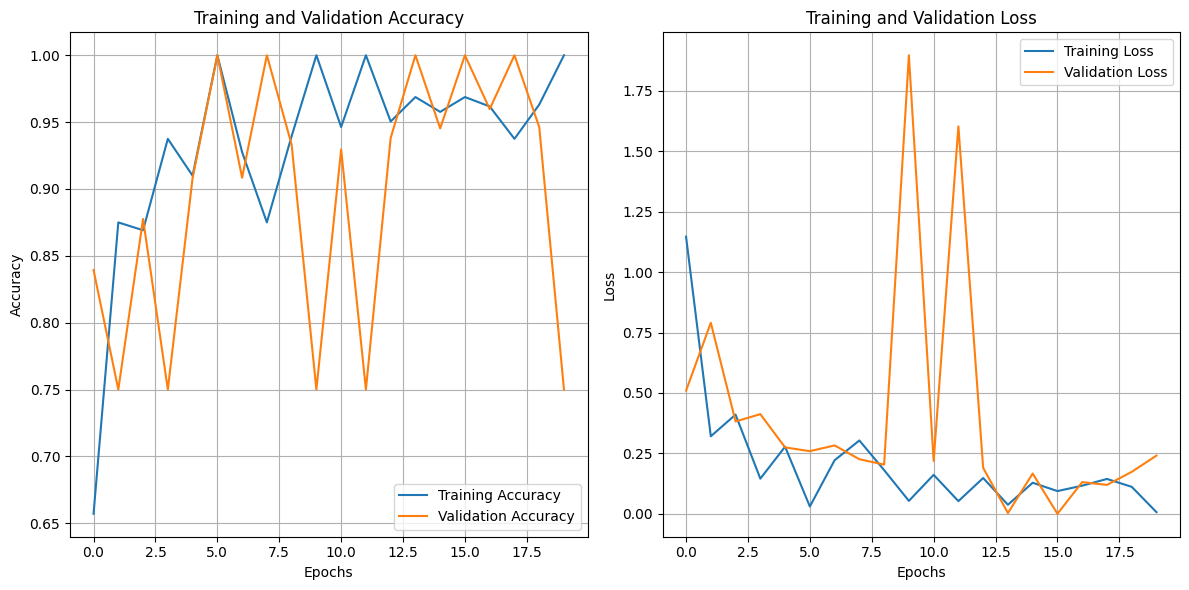

In [14]:
history = model.history

# Extract the history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs_range = range(len(training_accuracy))

# Plot training accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()